In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None #Leaf node has no backward, so by default it returns None
    self._prev = set(_children)
    self._op = _op #Defines what operation made the expression for Graphviz
    self.label = label

  #Python uses this function to format the printed data
  def __repr__(self):
    return f"Value(data={self.data})"
  
  #Initiall Python cannot add them, so we create this function for addition
  def __add__(self, other):
     #For adding value objects to integers
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out
  
  '''The children tuple basically defines the children of an expression,
  Say c=a+b, then c's chindren are a and b,
  Will be used in Backprop'''
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  #Python can do a*2, but cannot 2*a, for that we define rmul which swaps the order 
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1
  

  #To implement negation, (-other)
  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



'''Basically when you write
a=Value(2.0)
b=Value(3.0)
and then you try adding and multiplying by simply writing:
a+b
a*b,
Python actually does:
a.__add__(b)
a.__mul__(b)'''

# a=Value(3.0)
# b=Value(4.9)
# d=a+b
# print(d)
# print(d._prev)
# print(d._op)



'Basically when you write\na=Value(2.0)\nb=Value(3.0)\nand then you try adding and multiplying by simply writing:\na+b\na*b,\nPython actually does:\na.__add__(b)\na.__mul__(b)'

In [4]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [5]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

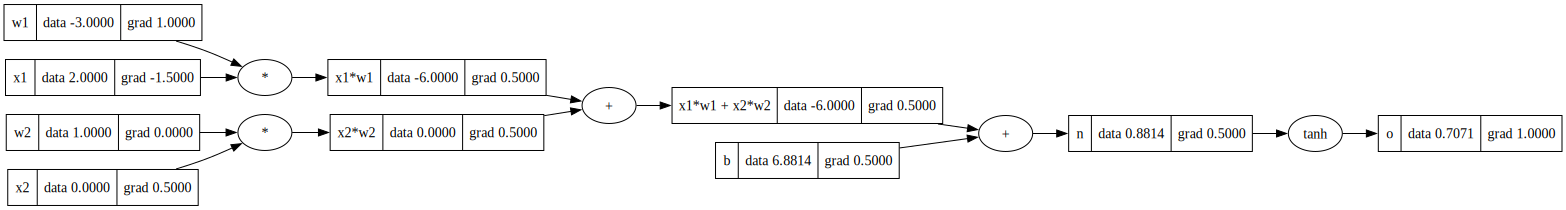

In [6]:
draw_dot(o)

In [7]:
'''Manual Backpropogation'''

# o.grad=1.0
# n.grad=1-o.data**2 #Derivative of tanh(x) wrt x is 1-tanh(x)**2
# x1w1x2w2.grad=n.grad
# x1w1.grad=n.grad
# x2w2.grad=n.grad
# b.grad=n.grad
# x1.grad=x1w1.grad*w1.data
# x2.grad=x2w2.grad*w2.data
# w1.grad=x1w1.grad*x1.data
# w2.grad=x2w2.grad*x2.data

'''Semi-Automatic Backpropogation'''
# o.grad=1.0  
# o._backward()
# n._backward()
# x1w1x2w2._backward()
# x2w2._backward()
# x1w1._backward()

'Semi-Automatic Backpropogation'

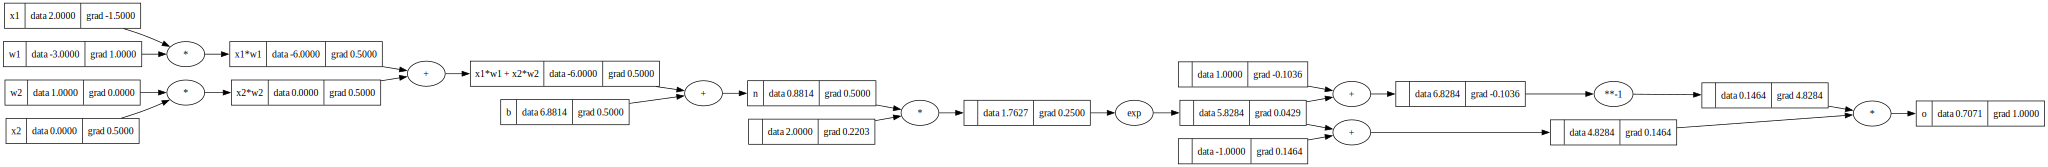

In [8]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [9]:
import torch

In [10]:

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [11]:

class Neuron:
  
  def __init__(self, nin):
    #nin is the number of inputs to the neuron
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]
 

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [17]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)
len(n.parameters()) # Weights and Biases



41

In [13]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

0 8.361077621629756
1 5.095281271136982
2 4.485985011503734
3 4.2317034918693786
4 4.0473552036704294
5 3.866839833665264
6 3.636950567423187
7 3.267210588609581
8 2.529894599624298
9 1.3933521658160835
10 0.7223014398532519
11 0.4480282695755139
12 0.3151652135969679
13 0.2407399464365933
14 0.19333250131383534
15 0.1607406304779118
16 0.13709101914027955
17 0.11921702407159693
18 0.10527266349142536
19 0.0941142986313039


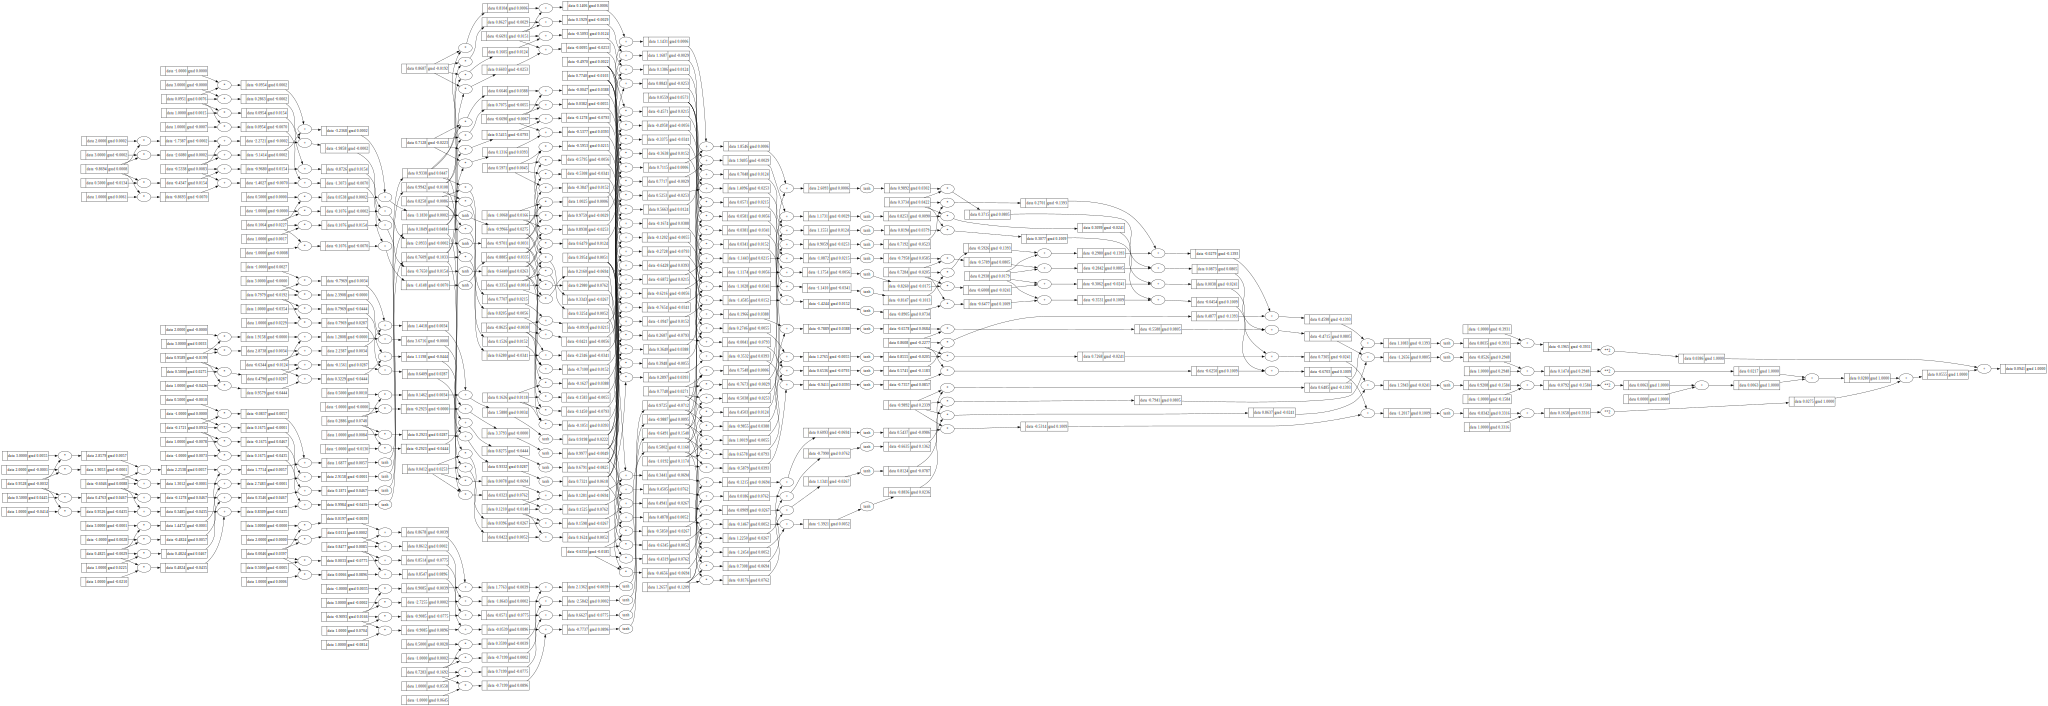

In [18]:
for k in range(20):  
    #forward pass  
    ypred=[n(x) for x in xs]
    loss=sum((yout - ygs)**2 for yout,ygs in zip(ypred,ys))

    #backward pass
    for p in n.parameters():
        p.grad=0
    loss.backward()

    #update
    for p in n.parameters():
        p.data+= -0.05*p.grad #Learning Rate 0.01

    print(k,loss.data)


draw_dot(loss)
